# FINAL PROJECT
SERGIO QUERALTÓ and
MIGUEL BARROSO

## 1. INTRODUCTION

The main objective of this project is to examine images of Pneumonia. Pneumonia, which remains a serious global health problem, impacting numerous individuals annually. Prompt diagnosis is essential to prevent serious complications, and doctors usually rely on clinical evaluations and imaging techniques, especially x-rays. These images can help detect irregularities such as pulmonary infiltrates or consolidations, which are common signs of pneumonia. However, manual processing of X-rays can be challenging and inconsistent at times, especially in resource-poor areas where expert radiologists are not always available. In recent years, the advance of artificial intelligence and machine learning in the field of medical diagnostics has been significant. The Convolutional Neural Networks (CNNs) have proven to be extremely efficient in image interpretation, including the identification of pneumonia on chest x-rays.

These models can be trained on large datasets. Our dataset encompasses thousands of labeled chest In this project, we will use PySpark, a Python, to develop an effective and scalable pneumonia detection system. PySpark is especially beneficial for handling large datasets and performing distributed computations. This strategy not only boosts computational efficiency, but also ensures that our system can be expanded to accommodate larger volume datasets and more complex models in the future. Our objective is to contribute to the expansive research on the applications of Artificial Intelligence in the health sector. By creating a reliable pneumonia detection model, we aim to encourage early diagnosis and improve patient outcomes.

We're documenting the entire process in a GitHub repository, allowing others to review, duplicate or improve and decided to work on google colab because of its facilities to work simultaneously in the same enviroment.

In [ ]:
# Connecting to Google Dirve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. IMPORT AND LOAD DATA

In [ ]:
# Importing standard libraries for file operations, randomization, and array manipulations
import os
import glob
import zipfile
import random as rn
import numpy as np
import pandas as pd

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing image processing libraries
import cv2
from PIL import Image

#Install pyspark
!pip install -q pyspark

# Importing PySpark for distributed data processing
from pyspark.sql import SparkSession

# Importing TensorFlow and keras for deep learning model creation
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Importing scikit-learn for evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# Coping the kaggle API to the Google Colab
!cp "/content/drive/MyDrive/BigData/" "/content"
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Downloading the data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzziping the data and storing into /tmp
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

cp: cannot stat '/content/drive/MyDrive/BigData/': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:33<00:00, 56.7MB/s]
100% 2.29G/2.29G [00:33<00:00, 73.5MB/s]


In the dataset there are lot of files, we are only interesed in the .jpeg files of the train, test and validation directories

In [ ]:
# Define the paths
train_normal_dir = '/tmp/chest_xray/train/NORMAL/'
train_pneu_dir = '/tmp/chest_xray/train/PNEUMONIA/'

test_normal_dir = '/tmp/chest_xray/test/NORMAL/'
test_pneu_dir = '/tmp/chest_xray/test/PNEUMONIA/'

val_normal_dir = '/tmp/chest_xray/val/NORMAL/'
val_pneu_dir = '/tmp/chest_xray/val/PNEUMONIA/'

# Pick the jpeg files
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')

Once we have the interested files, we created the train, test and validation set

In [ ]:
# Create train, test, and validation.
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
for x in train_pneu_cases:
    train_list.append([x, 1])
for x in test_normal_cases:
    test_list.append([x, 0])
for x in test_pneu_cases:
    test_list.append([x, 1])
for x in val_normal_cases:
    val_list.append([x, 0])
for x in val_pneu_cases:
    val_list.append([x, 1])


#Shuffle process (to randomize the data)
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# Create the dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

In [ ]:
train_df.head(10)

,image,label
0,/tmp/chest_xray/train/PNEUMONIA/person1395_vir...,1
1,/tmp/chest_xray/train/NORMAL/NORMAL2-IM-0462-0...,0
2,/tmp/chest_xray/train/PNEUMONIA/person849_viru...,1
3,/tmp/chest_xray/train/PNEUMONIA/person1617_bac...,1
4,/tmp/chest_xray/train/NORMAL/IM-0463-0001.jpeg,0
5,/tmp/chest_xray/train/PNEUMONIA/person1433_vir...,1
6,/tmp/chest_xray/train/NORMAL/NORMAL2-IM-1142-0...,0
7,/tmp/chest_xray/train/PNEUMONIA/person293_viru...,1
8,/tmp/chest_xray/train/NORMAL/NORMAL2-IM-1109-0...,0
9,/tmp/chest_xray/train/PNEUMONIA/person298_bact...,1


## 3. VISUALIZATION

The next step was visualizating the dataset to inspect the raw images directly from the training, validation, and test directories. This step was needed to verify that the images are loaded correctly and are of the expected quality and format. This step is performed before applying any preprocessing or transformations.

### 3.1 Images visualitation

We created a function to display some of the iamges of the dataset. The visualization allows for an intuitive understanding of the data distribution across the dataset and helps confirm that the labels are correctly associated with the images.

In [ ]:
label_mapping = {
    0: "Normal",
    1: "Pneumonia"
}

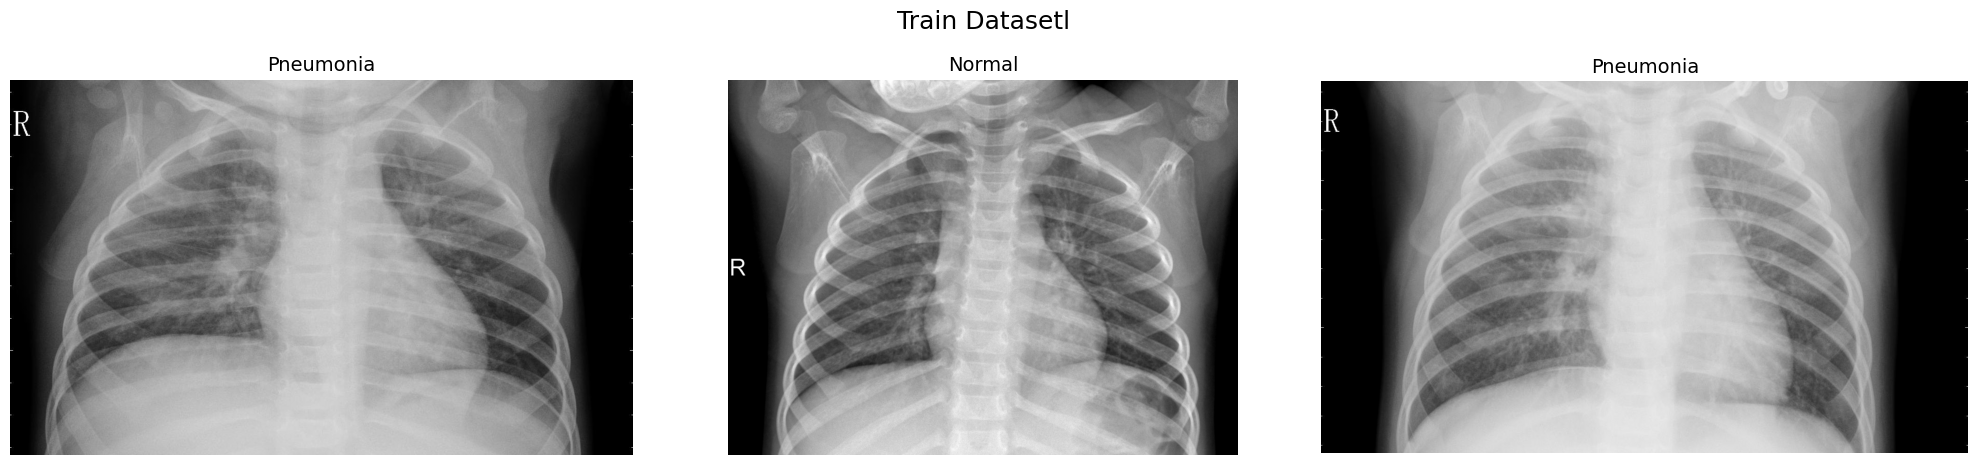

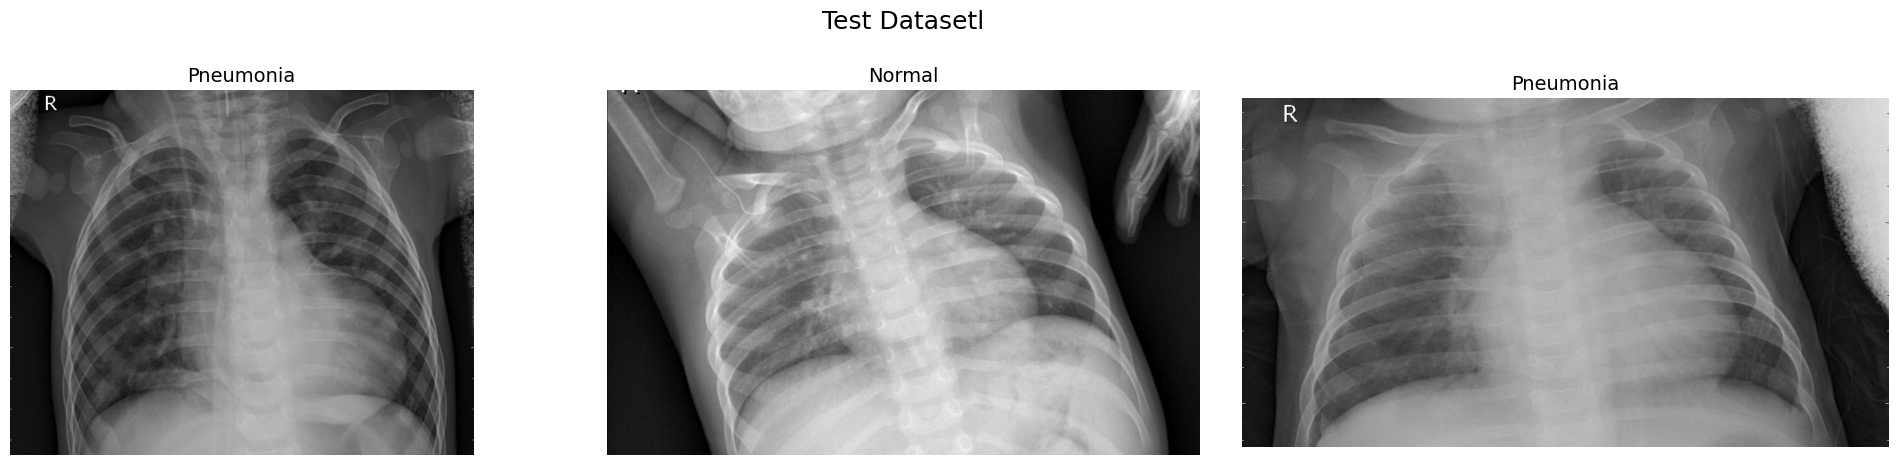

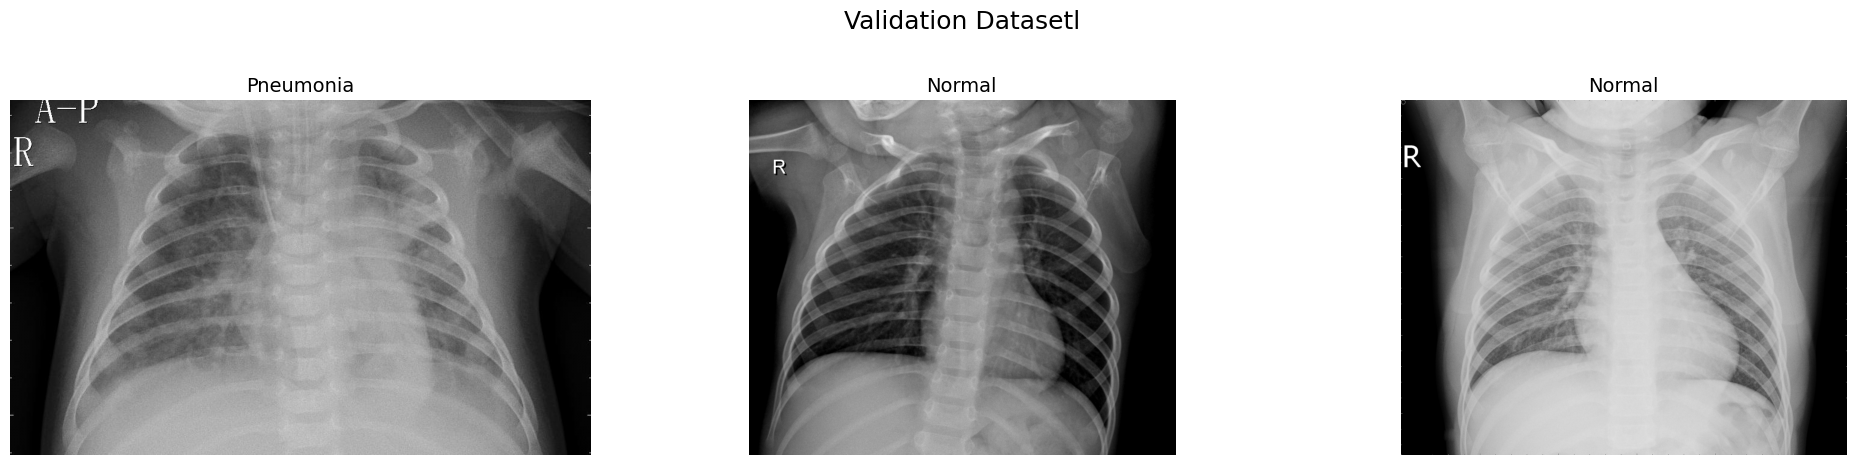

In [ ]:
def visualize_images_with_labels(df, num_images=6, title="Image Visualization", label_mapping=None):
    plt.figure(figsize=(20, 5))
    rows = num_images // 3 + (num_images % 3 > 0)  # Calculate rows for grid layout
    cols = 3

    for i in range(min(num_images, len(df))):
        # Load image and get label
        img = Image.open(df['image'].iloc[i])
        label = df['label'].iloc[i]
        if label_mapping:
            label = label_mapping[label]  # Map numeric label to class name

        # Add subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{label}", fontsize=14)
        plt.axis('off')

    plt.suptitle(title, fontsize=18, y=0.92)
    plt.tight_layout()
    plt.show()

# Example usage
label_mapping = {0: "Normal", 1: "Pneumonia"}
visualize_images_with_labels(train_df, num_images=3, title="Train Datasetl\n\n", label_mapping=label_mapping)
print("")
visualize_images_with_labels(test_df, num_images=3, title="Test Datasetl\n\n", label_mapping=label_mapping)
print("")
visualize_images_with_labels(val_df, num_images=3, title="Validation Datasetl\n\n", label_mapping=label_mapping)

**Figure 1. Raw Chest X-Ray images from Train, Test, and Validation Sets.** Each image is annotated with its label, which can be mapped to a human-readable class name (e.g., "Normal" or "Pneumonia") using a provided label mapping dictionary.

### 3.2 Plot representation

To get a clearer picture of the dataset, a second round of visualizations was done to check the label distribution across the training, test, and validation sets. Bar plots were used to compare the number of "Normal" and "Pneumonia" samples in each dataset.

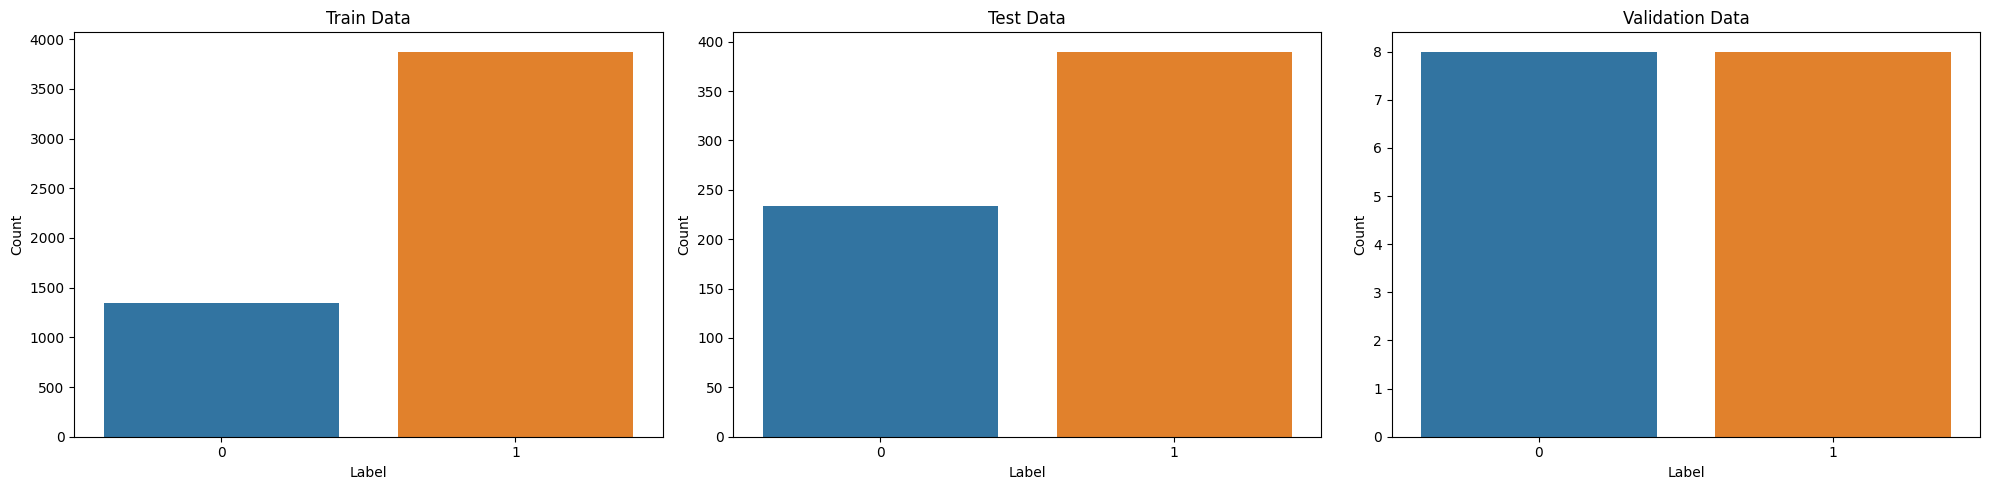

In [ ]:
# Create plots to represent the number of normal/pneumonia in the different sets.
plt.figure(figsize=(20, 5))

# Train plot
plt.subplot(1, 3, 1)
sns.countplot(x='label', data=train_df, hue='label', legend=False)
plt.title('Train Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Test plot
plt.subplot(1, 3, 2)
sns.countplot(x='label', data=test_df, hue='label', legend=False)
plt.title('Test Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Validation plot
plt.subplot(1, 3, 3)
sns.countplot(x='label', data=val_df, hue='label', legend=False)
plt.title('Validation Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the subplot
plt.tight_layout()
plt.show()

**Figure 2. Data Distribution Across Train, Test, and Validation Sets.** The three bar plots illustrate the distribution of class labels (0 and 1) in the training, test, and validation datasets. The training data shows a class imbalance, with label 1 being more frequent. The test set also reflects this imbalance but to a lesser extent, while the validation set is balanced, ensuring fair model evaluation.

In [ ]:
def count_labels(df, label_mapping=None):
    if label_mapping:
        df['label'] = df['label'].map(label_mapping)  # Map numeric labels to class names
    return df['label'].value_counts()

# Define the label mapping
label_mapping = {0: "Normal", 1: "Pneumonia"}

# Count labels in each DataFrame
train_counts = count_labels(train_df, label_mapping)
test_counts = count_labels(test_df, label_mapping)
val_counts = count_labels(val_df, label_mapping)

# Print results
print("Train Dataset Counts:")
print(train_counts)
print("\nTest Dataset Counts:")
print(test_counts)
print("\nValidation Dataset Counts:")
print(val_counts)


Train Dataset Counts:
label
Pneumonia    3875
Normal       1341
Name: count, dtype: int64

Test Dataset Counts:
label
Pneumonia    390
Normal       234
Name: count, dtype: int64

Validation Dataset Counts:
label
Pneumonia    8
Normal       8
Name: count, dtype: int64


This analysis highlights the prevalence of pneumonia cases in the dataset, a factor to consider during model training and evaluation to ensure balanced performance across classes. Also the training set is the biggest dataset.

## 4. PREPROCESSING

The preprocessing step prepares the images and labels for training by standardizing their format and scaling pixel values. This helps keep the data consistent and ready for the deep learning model. The fisrt step is to initialize the spark session.

In [ ]:
appname = "Final Project - Pneumonia identification "
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

In [ ]:
# Function to preprocess images
def process_image(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img_resized = img.resize(target_size)
        return np.array(img_resized).astype('float32') / 255.0  # Normalize pixel values
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# Function to compose dataset using Spark DataFrame
def compose_dataset_spark(df_spark, target_size=(224, 224)):
    images = []
    labels = []

    for row in df_spark.collect():
        img_array = process_image(row.image, target_size)
        if img_array is not None:
            images.append(img_array)
            labels.append(row.label)

    images = np.array(images).reshape(-1, target_size[0], target_size[1], 1) # Chanel 1
    labels = np.array(labels)

    return images, labels


In [ ]:
# Create Spark DataFrames
train_df = spark.createDataFrame(train_list, ["image", "label"])
test_df = spark.createDataFrame(test_list, ["image", "label"])
val_df = spark.createDataFrame(val_list, ["image", "label"])

# Applying functions to datasets (train, test, validation)
X_train, y_train = compose_dataset_spark(train_df)
X_test, y_test = compose_dataset_spark(test_df)
X_val, y_val = compose_dataset_spark(val_df)

# Print dataset shapes
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 224, 224, 1), Labels shape: (5216,)
Test data shape: (624, 224, 224, 1), Labels shape: (624,)
Validation data shape: (16, 224, 224, 1), Labels shape: (16,)


After preprocessing, the printed shapes confirm that the images and labels have been properly processed and formatted for deep learning. Each dataset—training, testing, and validation—maintains consistent dimensions, with images resized to (224, 224, 1) and labels correctly aligned. This shows that the preprocessing pipeline worked as expected, ensuring the grayscale images are normalized and well-structured. With this setup, the datasets are ready for smooth training, evaluation, and validation of the model.

## 5. MODEL BUILDING

In this section, a Convolutional Neural Network (CNN) model is built to classify chest X-ray images into two categories: "Normal" and "Pneumonia." The model is designed with layers that extract relevant features from the images, followed by data augmentation techniques to improve generalization and prevent overfitting during training. We tried different parameters and this was the one that had the best accuracy.

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Before training the model, data augmentation is applied with ImageDataGenerator, adding random transformations like rotation, shifting, shear, zoom, and horizontal flips to the training images. This helps the model generalize better by exposing it to different variations of the data, making it more resilient to overfitting.

In [ ]:
# Data augmentation for better generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Check the shape after encoding
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (5216, 2)
y_val shape: (16, 2)
y_test shape: (624, 2)


In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=10,
    callbacks=callbacks,
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 419s 13s/step - accuracy: 0.7305 - loss: 1.5860 - val_accuracy: 0.9310 - val_loss: 0.1775 - learning_rate: 0.0010
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 404s 12s/step - accuracy: 0.9340 - loss: 0.1684 - val_accuracy: 0.9636 - val_loss: 0.1044 - learning_rate: 0.0010
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 454s 13s/step - accuracy: 0.9630 - loss: 0.0980 - val_accuracy: 0.9550 - val_loss: 0.1163 - learning_rate: 0.0010
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 461s 13s/step - accuracy: 0.9715 - loss: 0.0892 - val_accuracy: 0.9693 - val_loss: 0.0909 - learning_rate: 0.0010
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 427s 13s/step - accuracy: 0.9759 - loss: 0.0622 - val_accuracy: 0.9722 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 448s 13s/step - accuracy: 0.9828 - loss: 0.0489 - val_accuracy: 0.9751 - val_loss: 0.0852 - learning_rate: 0.0010
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 423s 13s/step - accuracy: 0.9852 - loss: 0.0525 - 

After training, the model will be evaluated for its ability to accurately classify the images as either "Normal" or "Pneumonia," and adjustments can be made based on the results of this evaluation.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,721,224 (273.59 MB)

 Trainable params: 23,907,074 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,814,150 (182.40 MB)

Since the model run very slowly, we save it.

In [ ]:
model.save("/content/drive/MyDrive/BigData/model1_finalproject.keras")

In [ ]:
model = keras.saving.load_model("/content/drive/MyDrive/BigData/model1_finalproject.keras")

## 6. EVALUATION

In this step, the trained CNN model is tested on the unseen test dataset to evaluate its performance. The reported accuracy gives an idea of how well the model generalizes to new, real-world data. This helps determine if it can reliably classify chest X-ray images as "Normal" or "Pneumonia."

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7321 - loss: 1.3925
Test Accuracy: 0.75


### 6.2 Confusion Matrix

To further evaluate the model’s performance, we generate a confusion matrix and a classification report. The confusion matrix shows the number of true positives, true negatives, false positives, and false negatives, giving a clear view of how well the model distinguishes between classes. The classification report adds more detail with precision, recall, and F1-score for each class, helping assess both accuracy and overall reliability.

By analyzing these metrics, we can identify areas for improvement—like reducing false positives or false negatives—depending on the specific goal, such as detecting pneumonia more effectively.

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 930ms/step


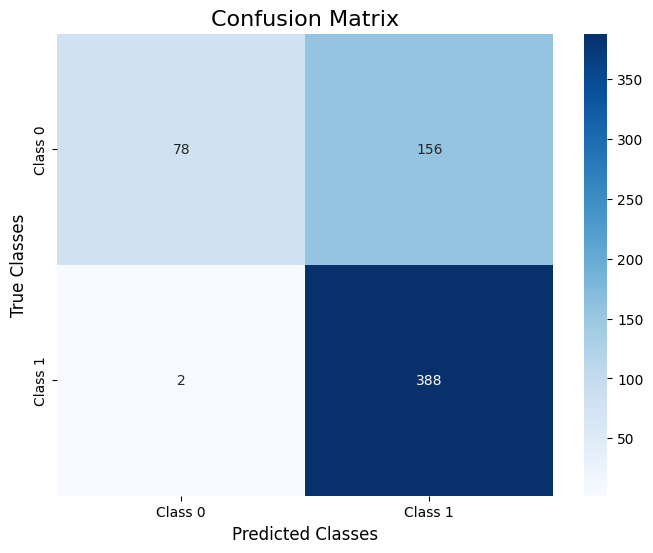

Classification report on test data:
              precision    recall  f1-score   support

     Class 0       0.97      0.33      0.50       234
     Class 1       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.75      0.71       624



In [ ]:
# Convert y_test from one-hot encoding to class labels
y_test_classes = y_test.argmax(axis=1)

# Obtain model predictions
y_pred = model.predict(X_test)

# Convert predictions to classes
y_pred_classes = y_pred.argmax(axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Create a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Classes', fontsize=12)
plt.ylabel('True Classes', fontsize=12)
plt.show()

# Classification report
clas_r = classification_report(y_test_classes, y_pred_classes, target_names=['Class 0', 'Class 1'])
print('Classification report on test data:')
print(clas_r)

**Figure 3. Confusion Matrix for Model Performance.** The confusion matrix illustrates the classification performance of the model. The diagonal elements (78 and 388) represent correctly classified instances, while the off-diagonal elements (2 and 156) indicate misclassifications. The model performs well but shows a higher misclassification rate for class 1 (false negatives) compared to class 0 (false positives).

## 7. PREDICTION RESULTS

In this section, the model's performance is evaluated using the validation dataset. Predictions are made on the validation images, and a subset of these images is visualized along with their predicted and true labels. This allows for a visual inspection of the model's accuracy and gives insights into any misclassifications, providing a clear understanding of how well the model generalizes to unseen data.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


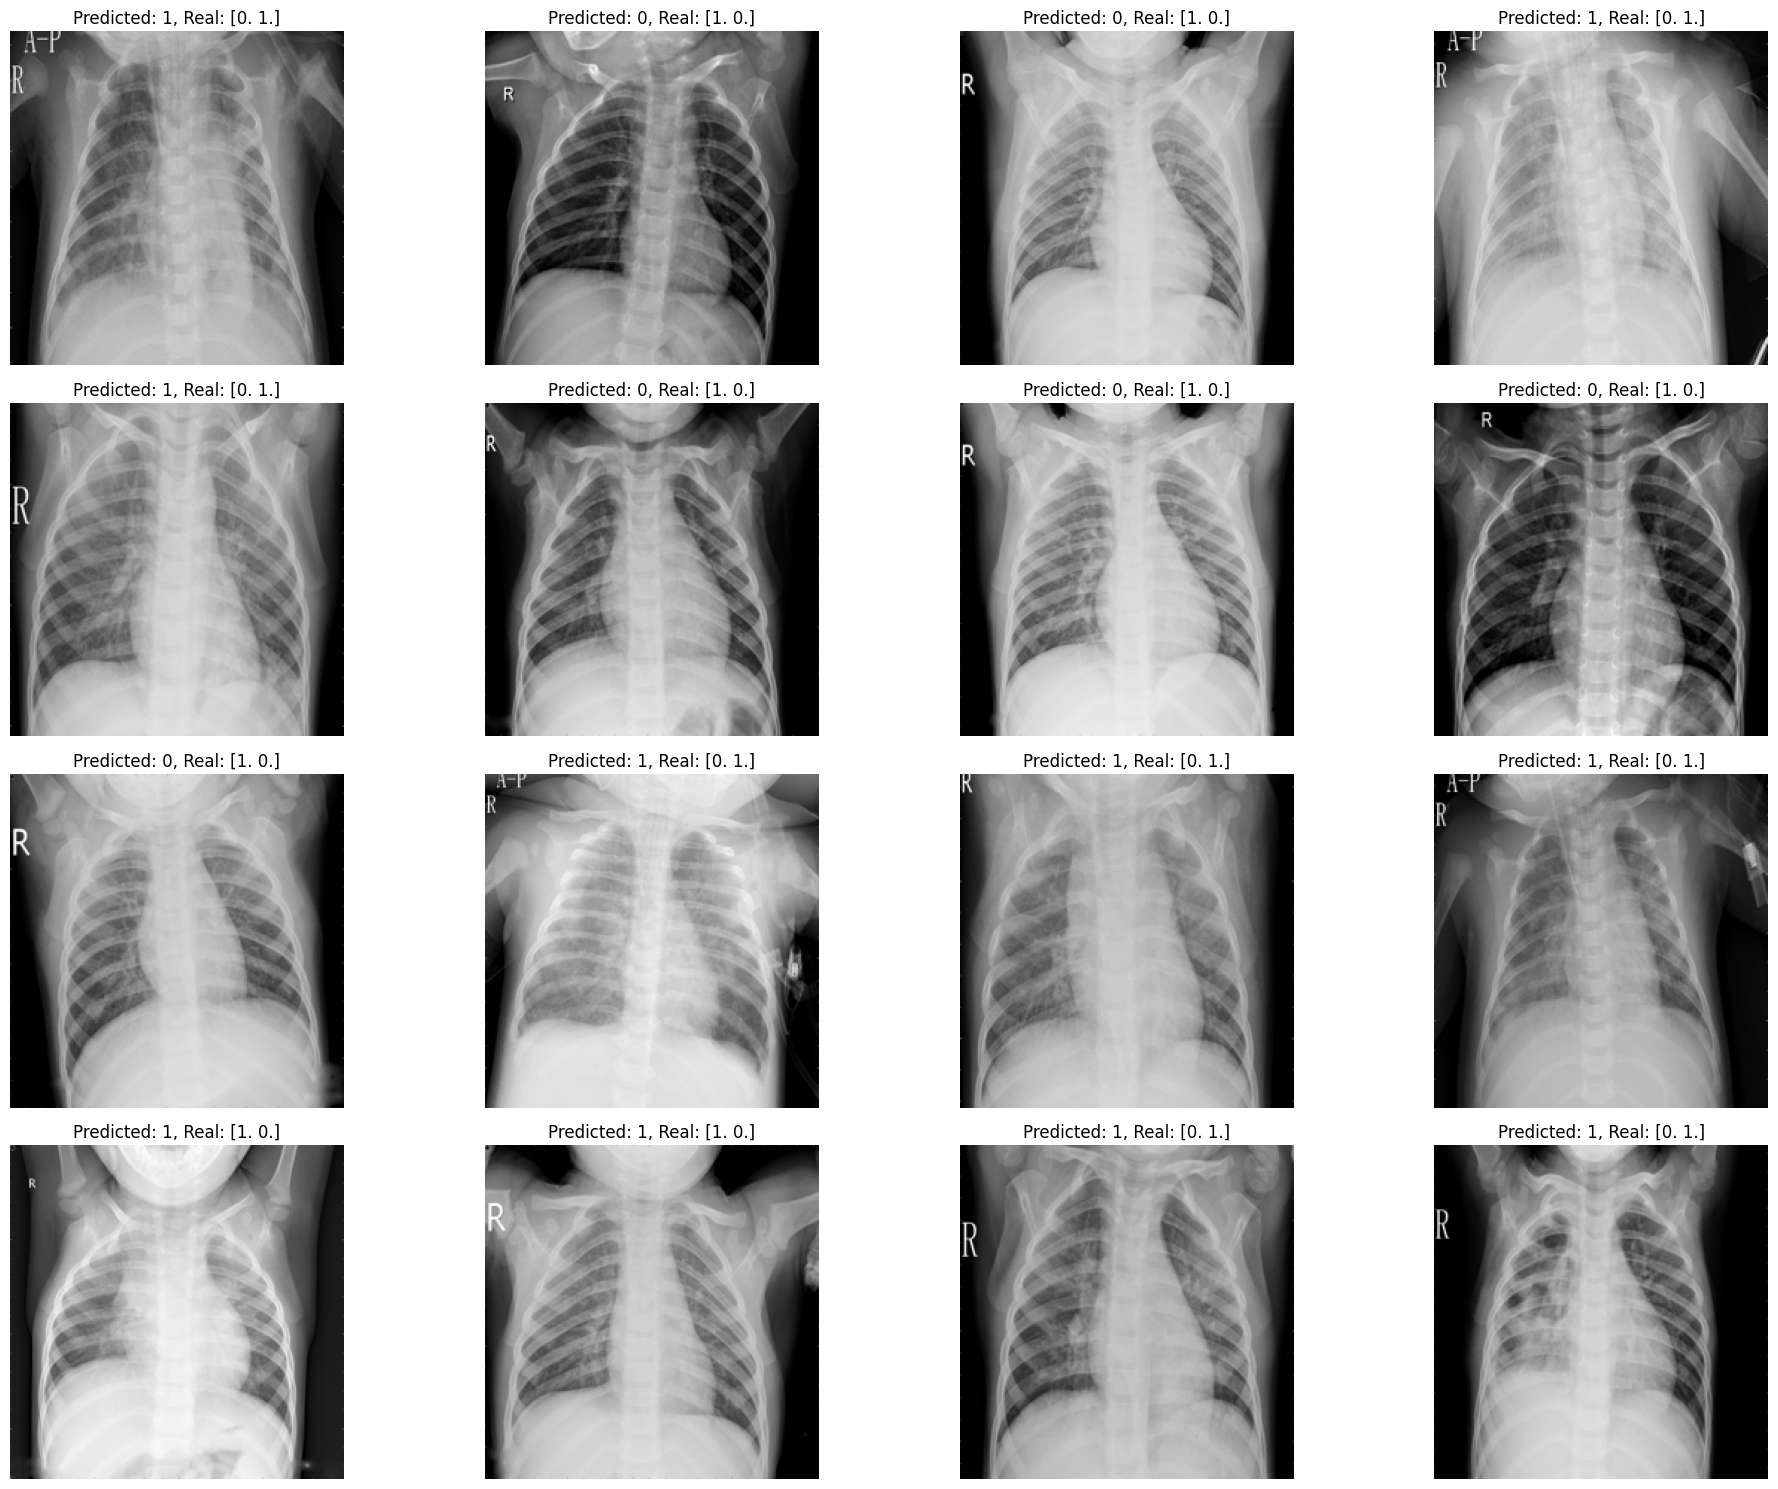

In [ ]:
# Get model predictions on the validation set
y_val_hat = model.predict(X_val, batch_size=4)  # Adjust the batch size if needed
y_val_hat = np.argmax(y_val_hat, axis=1)  # Convert probabilities to predicted classes
# Visualize some examples with predictions and true labels
plt.figure(figsize=(20, 15))
for i, x in enumerate(X_val[:16]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x.reshape(224, 224), cmap='gray')  # Display as grayscale (224x224)
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))
plt.tight_layout()
plt.show()

**Figure 4. Model Predictions on Chest X-ray Images.** Set of chest X-ray images with the predicted and real labels displayed above each image. The images are arranged in a grid to visualize the model's performance.

## 8. CONCLUSION

The project successfully demonstrated the potential of convolutional neural networks (CNNs) in medical image classification, particularly in detecting pneumonia from chest X-ray images. The model achieved an accuracy of 75%, which is a promising result but leaves room for improvement. While this accuracy is good for a basic implementation, there are several ways in which the model's performance could be enhanced. One approach could be to experiment with deeper or more complex architectures. Implementing more advanced data augmentation techniques, such as random rotations, flips, or color variations, could also help the model become more robust to different image orientations or lighting conditions. Additionally, leveraging transfer learning from pre-trained models could significantly boost accuracy by allowing the model to utilize pre-learned features from larger, diverse datasets.

Another important point to mention is the attempt to use the BigDL package for distributed deep learning with Apache Spark, which presented several challenges. Unfortunately, we encountered multiple errors when integrating BigDL with Spark, hindering our ability to fully exploit its potential for large-scale training and faster processing. These issues suggest that further investigation into BigDL’s compatibility and troubleshooting with Spark might be needed, or an alternative distributed deep learning framework might be considered.

The project also highlighted the importance of data quality and preprocessing. Ensuring a more diverse and comprehensive dataset could improve the model's ability to generalize, making it more reliable across different populations. Future work could focus on fine-tuning the model, exploring better architectures, improving data handling, and resolving technical issues with distributed systems for scalability.

In conclusion, while the current model's 72% accuracy is a good starting point, there is still substantial room for improvement. The integration of machine learning in medical diagnostics is an exciting and evolving field, and with continued advancements in model design, data augmentation, and distributed computing, the accuracy and robustness of such models will continue to improve for clinical use.